# Coloviu TIA
---
## Balas Vlad-George, Patrascu Gabriel

Scopul colocviul este de a determina nivelul de CO2 dintr-o zi anume pe baza restului datelor din acea zi.
Modul de lucru:
    - curatarea valorilor inexisente
    - eliminarea anomaliilor din coloanele alese
    - reducerea dimensionalitatii
    - predictie cu doua metode
        - SVM
        - Ridge



In [2]:
from sklearn.tree import DecisionTreeRegressor
from tensorflow.python.layers.core import dropout
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features

# metadata
print(air_quality.metadata)

# variable information
print(air_quality.variables)

2026-01-13 16:01:31.936778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vlad/Repos/Colocviu-TIA/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

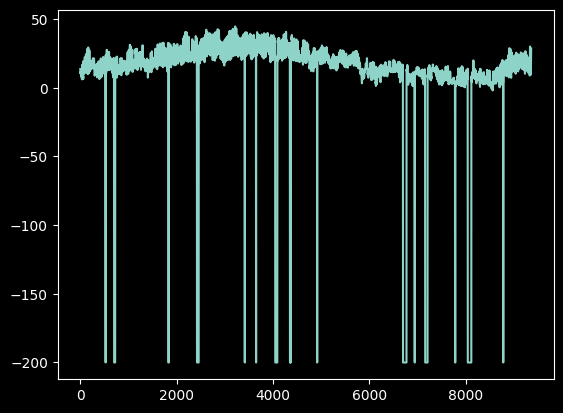

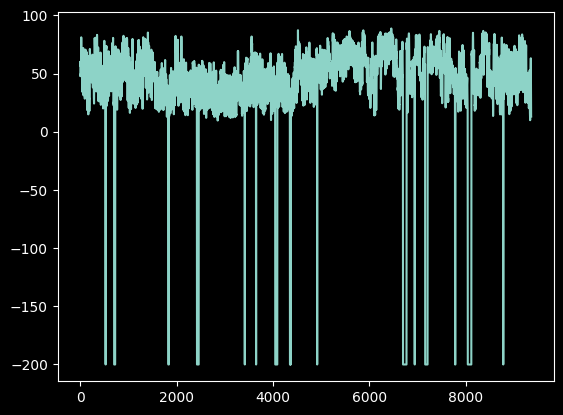

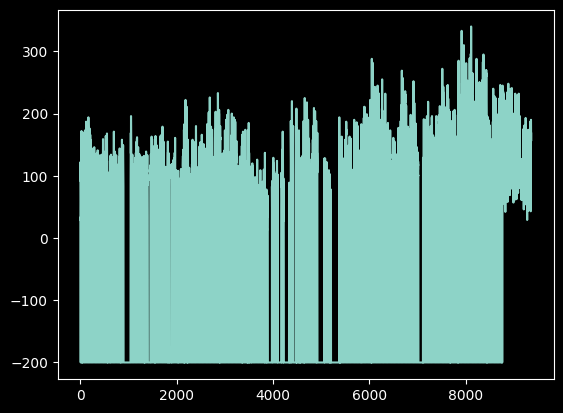

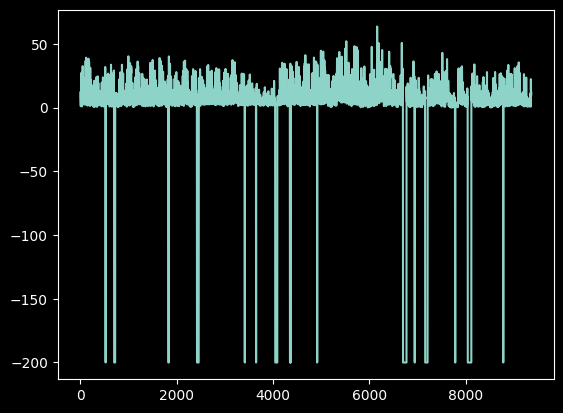

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

############################# PLOTARE DATE INIȚIALE #############################


# Alegem ca si coloane
# Temperatura, Anotimp ( obtinut din data ), Umiditate relativa, C6H6, NO2

plt.plot(X["T"], label="Temperature")
plt.show()

plt.plot(X["RH"], label="Relative humidity")
plt.show()

plt.plot(X["NO2(GT)"], label="NO2")
plt.show()

plt.plot(X["C6H6(GT)"], label="C6H6")
plt.show()





Dimensiune înainte de eliminare duplicate: (827, 15)
Dimensiune după eliminare duplicate: (827, 15)


/tmp/ipykernel_81528/3569775218.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw.drop_duplicates(inplace=True)


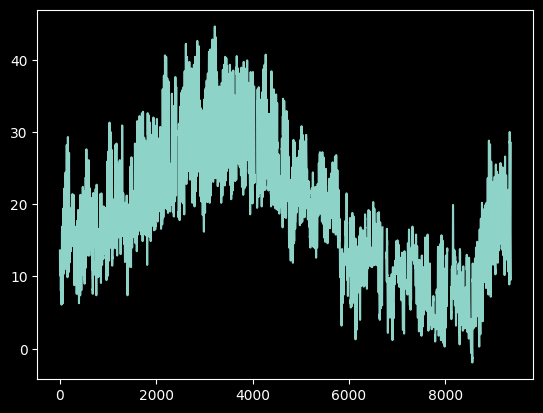

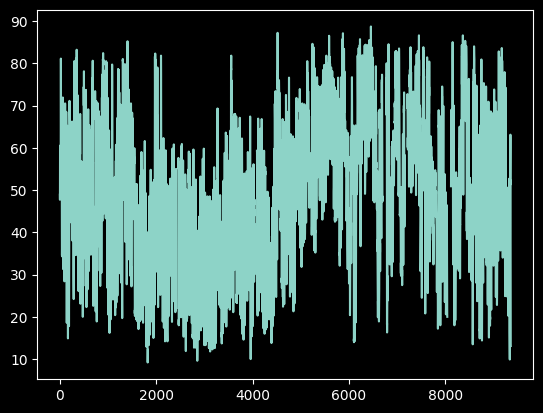

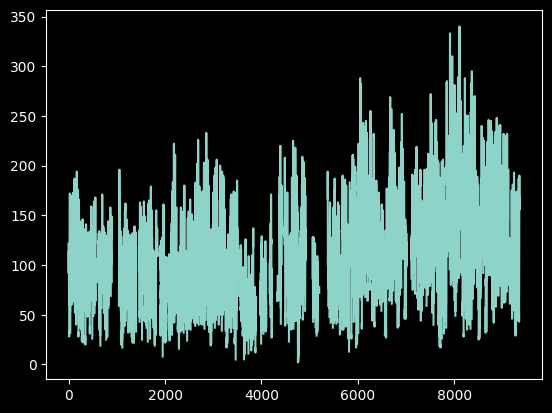

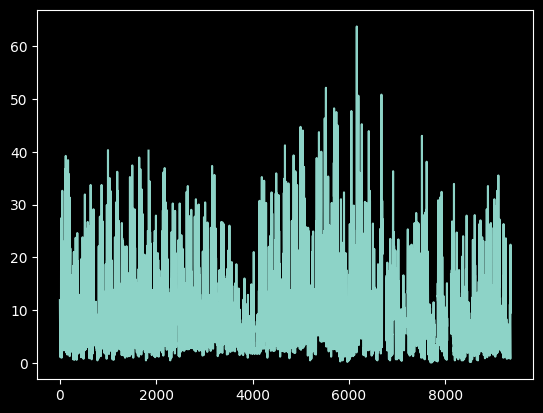

Date pregătite pentru modele: (827, 5)


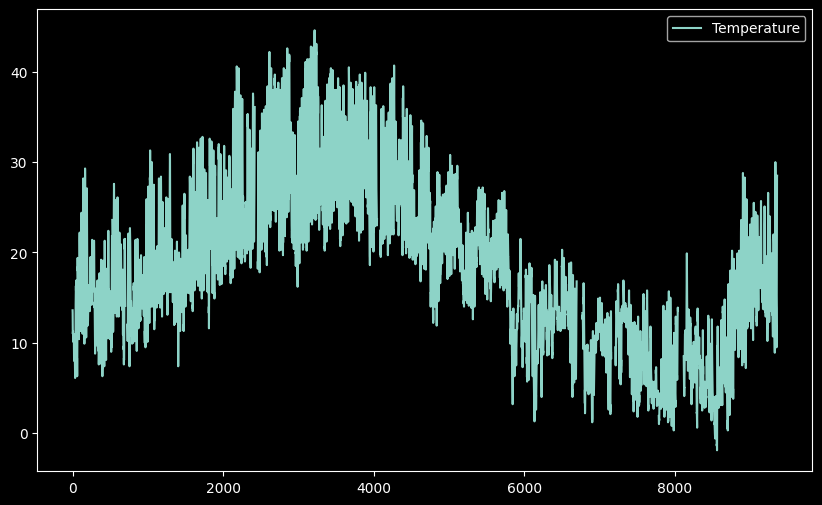

In [4]:
############################# ELIMINAERE VALORI GRESITE #############################

# Înlocuim -200 (marcajul pentru lipsă date) cu NaN
X.replace(-200, np.nan, inplace=True)

# Eliminăm rândurile care conțin NaN-uri (cea mai sigură metodă pentru "valori greșite")
data_raw = X.dropna()

############################# ELIMNARE DUPLICATE #############################

print(f"Dimensiune înainte de eliminare duplicate: {data_raw.shape}")
data_raw.drop_duplicates(inplace=True)
print(f"Dimensiune după eliminare duplicate: {data_raw.shape}")

# Separăm din nou X și y după curățare
# Selectăm coloanele relevante pentru X
features_initial = ["T", "RH", "NO2(GT)", "C6H6(GT)", "Date"]
X_clean = data_raw[features_initial].copy()
y_clean = data_raw['CO(GT)']

############################# PLOTARE DATE DUPĂ CURĂȚARE #############################


# Ploturile după curățare
plt.plot(X["T"], label="Temperature")
plt.show()

plt.plot(X["RH"], label="Relative humidity")
plt.show()

plt.plot(X["NO2(GT)"], label="NO2")
plt.show()

plt.plot(X["C6H6(GT)"], label="C6H6")
plt.show()


############################# TRANSFORMAREA DATEI ÎN ANOTIMP ȘI STANDARDIZARE #############################

# Transformarea datei în Anotimp
def get_season(date_str):
    # Formatul este DD/MM/YYYY
    month = int(date_str.split('/')[1])
    if month in [12, 1, 2]:
        return 1  # Iarna
    elif month in [3, 4, 5]:
        return 2  # Primavara
    elif month in [6, 7, 8]:
        return 3  # Vara
    else:
        return 4  # Toamna


X_clean['Season'] = X_clean['Date'].apply(get_season)

# Selectăm doar coloanele numerice finale pentru analiză (scoatem Data string)
numeric_cols = ["T", "RH", "NO2(GT)", "C6H6(GT)", "Season"]
X_final = X_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Standardizare (esențial pentru SVM și PCA care urmează)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

print(f"Date pregătite pentru modele: {X_scaled.shape}")

# Vizualizări (codul original + ajustări)
plt.figure(figsize=(10, 6))
plt.plot(X["T"], label="Temperature")
plt.legend()
plt.show()


In [5]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# --- Local Outlier Factor (KNN-based) ---
# n_neighbors=20 este standard. contamination='auto' detectează automat pragul.
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
pred_lof = lof.fit_predict(X_scaled)  # Returnează 1 (inlier) sau -1 (outlier)

# ---  One-Class SVM (OCSVM) ---
# kernel='rbf' este cel mai eficient pentru date neliniare
# nu=0.2 este o limită superioară pentru fracția de anomalii (similar cu contamination)
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
pred_ocsvm = ocsvm.fit_predict(X_scaled)

# --- Masca Comună (Intersecția) ---
# Păstrăm datele doar dacă AMBII algoritmi spun că sunt bune (1)
mask_common = (pred_lof == 1) & (pred_ocsvm == 1)

# Aplicăm masca
X_filtered = X_scaled[mask_common]
y_filtered = y_clean[mask_common]

print(f"Date rămase după LOF: {sum(pred_lof == 1)}")
print(f"Date rămase după OCSVM: {sum(pred_ocsvm == 1)}")
print(f"Date rămase după Masca Comună: {X_filtered.shape[0]}")

Date rămase după LOF: 815
Date rămase după OCSVM: 745
Date rămase după Masca Comună: 739


Varianța explicită: [0.50194265 0.24363403]


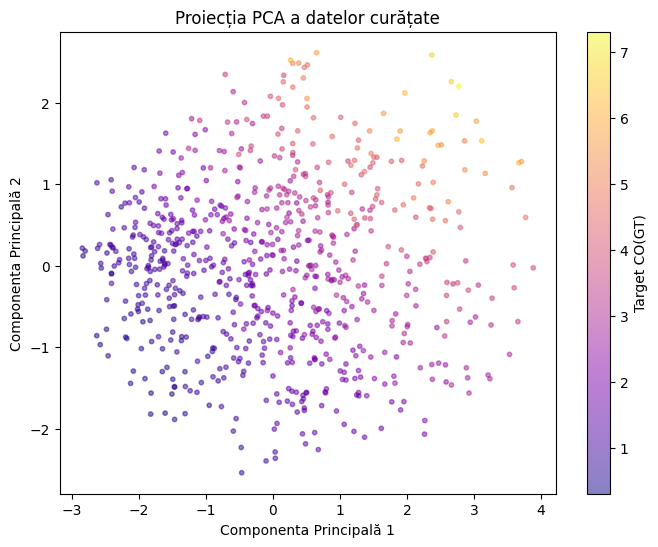

In [14]:

from sklearn.decomposition import PCA

# Inițializăm PCA pentru 2 componente (pentru vizualizare și simplificare)
pca = PCA(n_components=2)

# Fit și transform pe datele filtrate prin masca comună
X_pca = pca.fit_transform(X_filtered)

print(f"Varianța explicită: {pca.explained_variance_ratio_}")

# Vizualizare rapidă (opțional, bun pentru prezentarea de 10 min)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_filtered, cmap='plasma', s=10, alpha=0.5)
plt.colorbar(label='Target CO(GT)')
plt.title('Proiecția PCA a datelor curățate')
plt.xlabel('Componenta Principală 1')
plt.ylabel('Componenta Principală 2')
ax = plt.gca()
ax.set_facecolor('white')
plt.show()
# aplica PCA pe datele obtinute

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Împărțim datele PCA în Train și Test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_filtered, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# --- Model 1: Support Vector Regression (SVR) ---
svr = SVR(kernel='rbf', C=100, epsilon=0.1)  # C mai mare poate ajuta la regresie fină
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# --- Model 2: Ridge Regression ---
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# --- Model 3: RandomTreeRegressor ---
tree = RandomForestRegressor(n_estimators=100, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# --- Model 4: MLPRegressor ---
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# --- Calcul și Afișare Scoruri ---
print("=== Rezultate SVR ===")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_svr):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_svr):.4f}")

print("\n=== Rezultate Ridge ===")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_ridge):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_ridge):.4f}")

print("\n=== Rezultate RandomForrestRegressor ===")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_tree):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_tree):.4f}")

print("\n=== Rezultate MLP ===")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_mlp):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_mlp):.4f}")

(591, 2) (591,) (148, 2) (148,)
=== Rezultate SVR ===
Mean Squared Error (MSE): 0.0901
R2 Score: 0.9382

=== Rezultate Ridge ===
Mean Squared Error (MSE): 0.1196
R2 Score: 0.9180

=== Rezultate RandomForrestRegressor ===
Mean Squared Error (MSE): 0.1035
R2 Score: 0.9290

=== Rezultate MLP ===
Mean Squared Error (MSE): 0.0926
R2 Score: 0.9365


In [8]:
import tensorflow as tf

#--- Model 5: DNN ( studentul, dens si cu putini neuroni ) ---
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# train
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    verbose=1
)

y_pred_dnn = model.predict(X_test)
print("\n=== Rezultate DNN ===")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_dnn):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_dnn):.4f}")

/home/vlad/Repos/Colocviu-TIA/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1768312914.196930   81528 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/100


2026-01-13 16:01:55.377711: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ff4d400e1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-13 16:01:55.377726: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2026-01-13 16:01:55.395665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-13 16:01:55.516971: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


 1/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 6.7934 - mean_absolute_error: 2.2744

I0000 00:00:1768312916.538968   81636 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.3311 - mean_absolute_error: 2.4450
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5692 - mean_absolute_error: 2.3379 
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0936 - mean_absolute_error: 2.2717 
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7829 - mean_absolute_error: 2.2259 
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5661 - mean_absolute_error: 2.1911 
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4087 - mean_absolute_error: 2.1635 
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2841 - mean_absolute_error: 2.1400 
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1790 - mean_absolute_error: 2.1185 
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0857 - mean_absolute_error: 2.0983 
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9968 - mean_absolute_error: 2.0785 
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0